In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# load
with open('week1all_trained_PCA_2021-07-12.pickle', 'rb') as f:
    pca = pickle.load(f)
with open('week1all_trained_TLDA_2021-07-12.pickle', 'rb') as f:
    tlda = pickle.load(f)
id_map = np.load('week1all_id-word-map_2021-07-12.npy')

In [3]:
tlda.factors_.shape

(20, 20)

In [4]:
id_map.shape

(54,)

In [5]:
# extract topics and correct weights
probs = np.array(pca.reverse_transform(tlda.factors_))
total_topics = probs.shape[0]

probmaps = []
for i in range(total_topics):
    topids = probs[i,:].argsort()
    probmaps.append({id_map[word_id]: probs[i,word_id] for word_id in topids})

In [6]:
len(sorted(probmaps[0].items(), key=lambda x: x[1]))

54

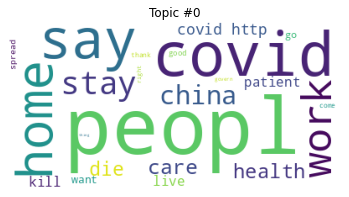

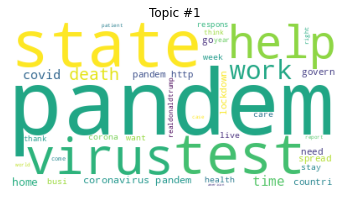

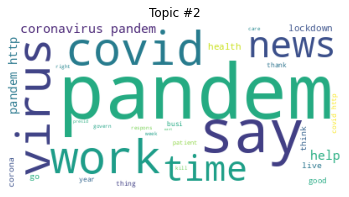

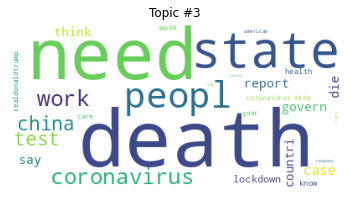

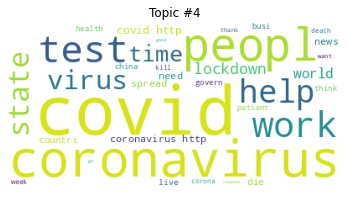

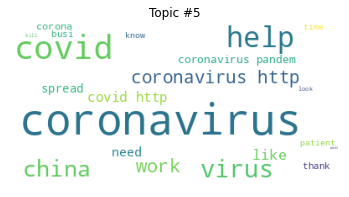

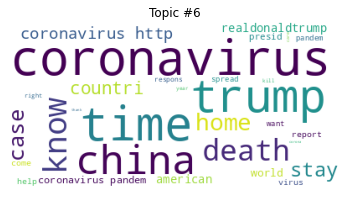

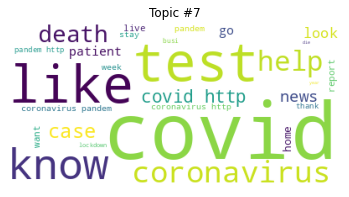

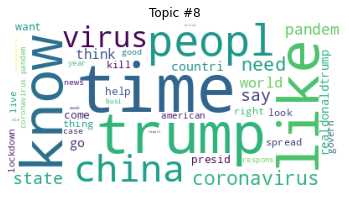

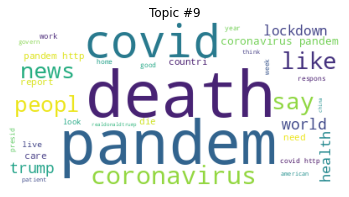

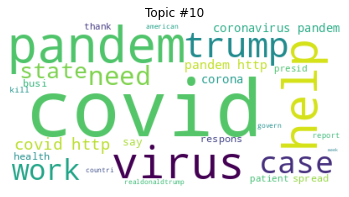

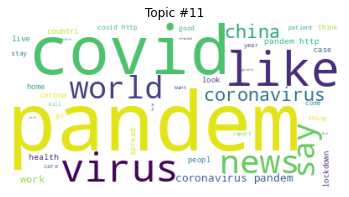

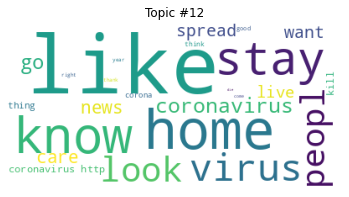

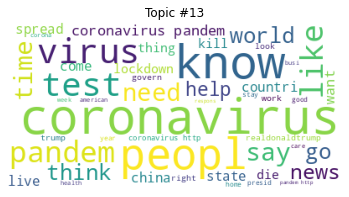

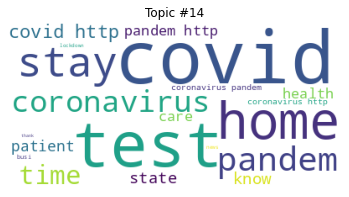

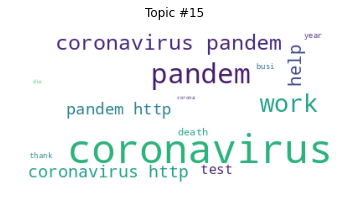

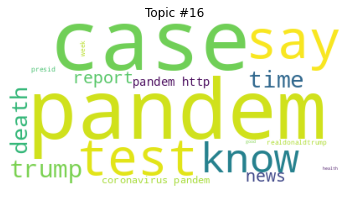

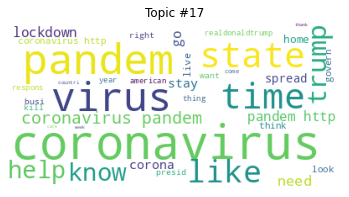

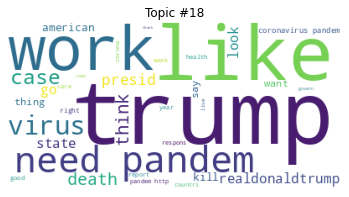

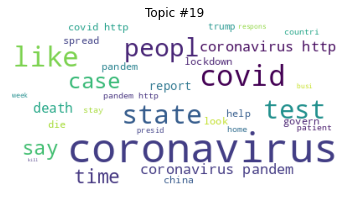

In [11]:
# draw word clouds
# fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for t in range(total_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(probmaps[t]))
    plt.axis("off")
    plt.title("Topic #" + str(t))

In [9]:
# plot toxicity rating(?) of each topic... there's no easily accessible hate speech lexicon!!!!